In [1]:
import pandas as pd
import numpy as np
import warnings 
import time, datetime
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
    """
        Module pour déterminer l'interval de maintenance
    """

In [2]:
# Fonction pour générer le fichier clients rfm avec une date
def generate_client_file(orders, date):

    # Convertir la colonne 'order_purchase_timestamp'en datetime
    orders['order_purchase_timestamp'] = pd.to_datetime\
        (orders['order_purchase_timestamp'])
    # Filtrer les commandes jusqu'à la date spécifiée   
    filtered_orders = orders[orders['order_purchase_timestamp'] \
                             <= date]
    # Créer fichier RFM 
    client_file = filtered_orders.loc[:, ['recence_norm', \
        'frequence_norm', 'montant_norm']].copy()
    return client_file

In [3]:
warnings.filterwarnings('ignore')
data =  pd.read_csv('data_rfm.csv',  engine = 'python', \
                    on_bad_lines = 'skip', index_col=[0])

In [4]:
last_buy = data['order_purchase_timestamp'].max()
print(last_buy)
first_buy = data['order_purchase_timestamp'].min()
print(first_buy)

2018-09-03 09:06:57
2016-09-04 21:15:19


In [8]:
# Paramètres
P0 = datetime.datetime(2017, 7, 1) # Date de début 
n_days = 16  # Nombre de jours entre deux simulations
n_clusters = 3
threshold_ARI = 0.8  # Seuil ARI pour déterminer l'obsolescence du modèle

In [9]:
# Boucle de simulation
start_time = time.time()
dates = []
ARI_scores = []

while P0 < datetime.datetime(2018, 8, 31):  
    
    # Générer le fichier clients initial F0
    F0 = generate_client_file(data, P0)

    # Entraîner le modèle initial M0
    scaler_M0 = StandardScaler()
    scaled_F0 = scaler_M0.fit_transform(F0)
    M0 = KMeans(n_clusters=n_clusters).fit(scaled_F0)
    C0 = M0.labels_

    # Simulation de maintenance périodique
    P1 = P0 + datetime.timedelta(days=n_days)
    F1 = generate_client_file(data, P1)

    # Entraîner le nouveau modèle M1
    scaler_M1 = StandardScaler()
    scaled_F1 = scaler_M1.fit_transform(F1)
    M1 = KMeans(n_clusters=n_clusters).fit(scaled_F1)
    C1_M1 = M1.labels_

    # Prédire les numéros clusters avec le modèle initial M0
    C1_M0 = M0.predict(scaler_M0.transform(F1))

    # Calculer l'ARI pour comparer les numéros de clusters
    ARI = adjusted_rand_score(C1_M0, C1_M1)
    print(f"ARI at P1: {ARI}")

    # Ajout date et ARI score au liste
    dates.append(P1)
    ARI_scores.append(ARI)
    
    # Vérifier l'obsolescence du modèle initial
    if ARI < threshold_ARI:
        print("Model M0 obsolete. Besoin de maintenance.")

    # Passer à la période suivante
    P0 += datetime.timedelta(days=n_days)

ARI at P1: 0.9078802068018504
ARI at P1: 0.8441457437398312
ARI at P1: 0.8251679118017794
ARI at P1: 0.8273388588298157
ARI at P1: 0.8562959597222866
ARI at P1: 0.8597118802352623
ARI at P1: 0.9060394834098554
ARI at P1: 0.932810876851162
ARI at P1: 0.8903902649094114
ARI at P1: 0.7973527232306734
Model M0 obsolete. Besoin de maintenance.
ARI at P1: 0.9174159054454114
ARI at P1: 0.9233444648740355
ARI at P1: 0.9141627771763867
ARI at P1: 0.930761361844732
ARI at P1: 0.90867098258173
ARI at P1: 0.9357560035105523
ARI at P1: 0.9291413228303351
ARI at P1: 0.9393132923508094
ARI at P1: 0.9302260733133425
ARI at P1: 0.9406327671603739
ARI at P1: 0.9605757578381864
ARI at P1: 0.7107265216323492
Model M0 obsolete. Besoin de maintenance.
ARI at P1: 0.8359497228944291
ARI at P1: 0.9654405905304313
ARI at P1: 0.8923222049633672
ARI at P1: 0.8546394558114753
ARI at P1: 0.9483365949116347


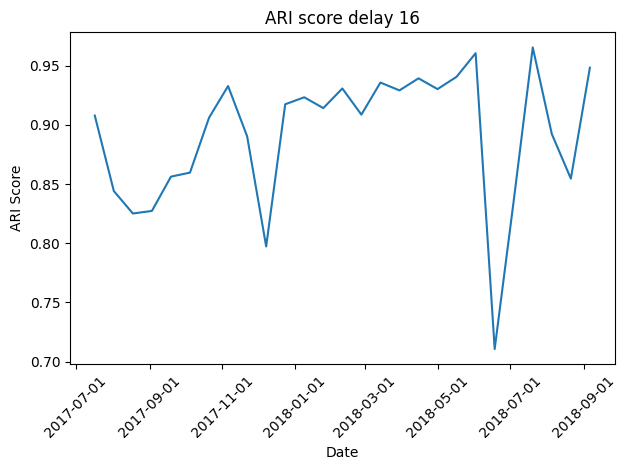

temps d'exec ARI =  26.188718795776367


In [10]:
# Display the dates and ARI scores
fig, ax = plt.subplots()
ax.plot(dates, ARI_scores)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_xlabel('Date')
ax.set_ylabel('ARI Score')
ARI_title = "ARI score delay " + str(n_days)
plt.title(ARI_title)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

end_time = time.time()
execution_time = end_time - start_time
print("temps d'exec ARI = ",execution_time )